In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import torch
import pickle
import config
import time
import IPython.display as IPd

from forward import Forward 
from survey import Survey
from util import *
from block_utils import *

# SBI imports
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi, likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi.utils import RestrictionEstimator
from sbi.utils import user_input_checks as uic
from sbi import analysis as analysis
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot


from torch.distributions import Distribution, Uniform, Normal
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from svgutils.compose import *

_ = torch.manual_seed(0)

2024-07-28 09:19:52.761143: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 09:19:52.802306: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 09:19:52.802346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 09:19:52.802371: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-28 09:19:52.811162: I tensorflow/core/platform/cpu_feature_g

In [2]:
max_resistivity = 1000
min_resistivity = 1
num_measurements = 23
num_dim = 7

#depths = np.linspace(0, max_depth, num=num_dim)
thicknesses = torch.ones(num_dim) * 0.5

In [3]:
# Survey Setup
survey, electrode_spacing = Survey(num_measurements, min_ab_distance=2, max_ab_distance=100).schlumberger_survey()


### Define Forward model

In [6]:
def dc_forward_block_noise(res_n_depth):
    '''
    Simulator used for generating the training set (noise level 5 \Omega m)
    returns the apparent resistiviy values from  a block sample. 
    '''
    number_of_layers = int( (len(res_n_depth)+1) /2)
    # First half of parameters is resistivities
    resistivities = res_n_depth[:number_of_layers]
    # Second half of parameters are thicknesses
    thicknesses = res_n_depth[number_of_layers:]
    forward = Forward(thicknesses, survey)
    
    return forward.dc_forward_model_base_noise(resistivities, 5)

In [7]:
n_blocks = 4 
res_prior_min = torch.as_tensor([min_resistivity] * n_blocks)
res_prior_max = torch.as_tensor([max_resistivity] * n_blocks)

n_thickness = 3
min_thickness = 0.1
max_thickness = 20.
thickness_prior_min = torch.as_tensor([min_thickness] * n_thickness)
thickness_prior_max = torch.as_tensor([max_thickness] * n_thickness)

prior_min = torch.cat([res_prior_min, thickness_prior_min])
prior_max = torch.cat([res_prior_max, thickness_prior_max])

prior_block = utils.BoxUniform(low=prior_min, high=prior_max)

In [8]:
train_model = False
filename_block = "pickled_objects/block_100k_1000_ohm_48points.pkl"
num_simulations = 100_000


if train_model:

    # Prepare forward model and prior for SBI Inference (forward model 5 dimensional no noise added)
    simulator, prior_block = prepare_for_sbi(dc_forward_block_noise, prior_block)
    inference_block = SNPE(prior=prior_block, device="cpu", show_progress_bars=True)

    remaining_simulations = num_simulations
    while remaining_simulations > 0:    
        theta, x = simulate_for_sbi(simulator, prior_block, remaining_simulations)
        valid_simulations = torch.all(~torch.isnan(x), dim=1)
        if any(valid_simulations):
            inference_block.append_simulations(theta[valid_simulations], x[valid_simulations] )  # Gather the new and valid simulations in the `restriction_estimator`.
            remaining_simulations -= torch.sum(valid_simulations).item()
        else: 
            continue

    
    #(all_theta, all_x, _, ) = inference_step.get_simulations()
    density_estimator = inference_block.train()

    posterior_block = inference_block.build_posterior(density_estimator)

    pickle_objects([inference_block, posterior_block], filename_block)
else:
    inference_block, posterior_block = unpickle_objects(filename_block)

## Expected Coverage

In [10]:
simulator, prior = prepare_for_sbi(dc_forward_block_noise, prior_block)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

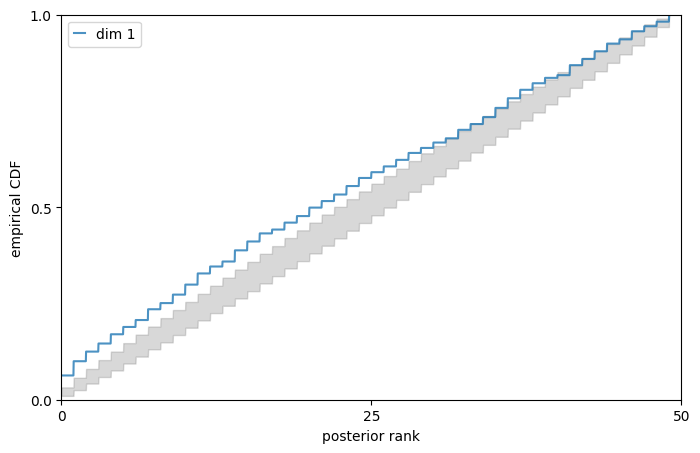

In [11]:
thetas = prior.sample((1_000,))
xs = simulator(thetas)

ranks, dap_samples = run_sbc(
    thetas, xs, posterior_block, num_posterior_samples=1_000, reduce_fns=posterior_block.log_prob
)

_ = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1_000,
    plot_type="cdf",
    num_bins=None,
)

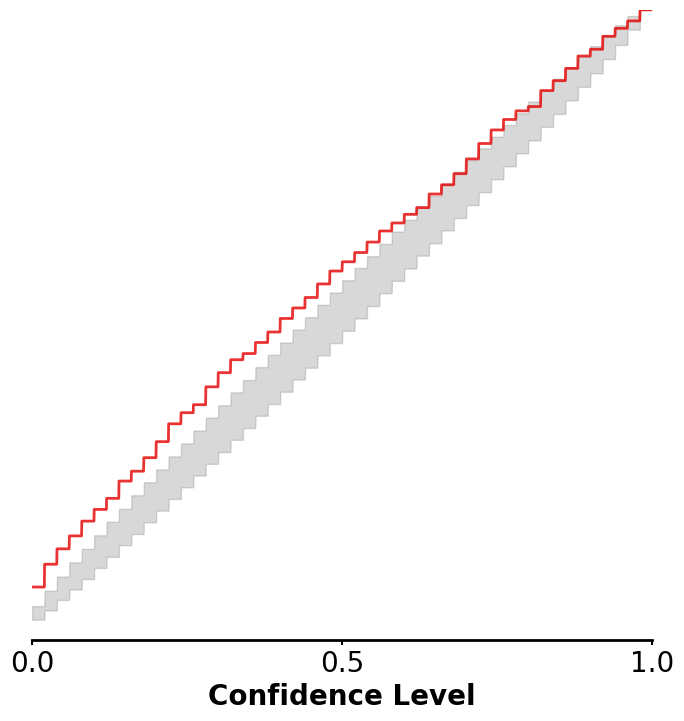

In [17]:
with mpl.rc_context(fname="plots/pltstyle.rc"):
    (fig, ax) = sbc_rank_plot(
        figsize=(8,8),
        ranks=ranks,
        num_posterior_samples=1_000,
        plot_type="cdf",
        num_bins=None,
        parameter_labels=[''],
        colors=['#e40000']
    )
    
    ax.set_xlabel('Confidence Level')
    ax.set_ylabel('Empirical Coverage')
    
    xticks = ax.get_xticks()
    
    # Normalize x-ticks to be in the range [0, 1]
    normalized_xticks = xticks / 50.0
    
    # Set the new x-tick labels
    ax.set_xticklabels([f'{tick:.1f}' for tick in normalized_xticks])
    
    # Hide the top and right spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    
    # Optionally, adjust the ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.spines['bottom'].set_position(('outward', 10)) 
    ax.spines['left'].set_position(('outward', 10)) 

    ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
    fig.savefig('plots/calibration/sbcc/block_cdf.svg')

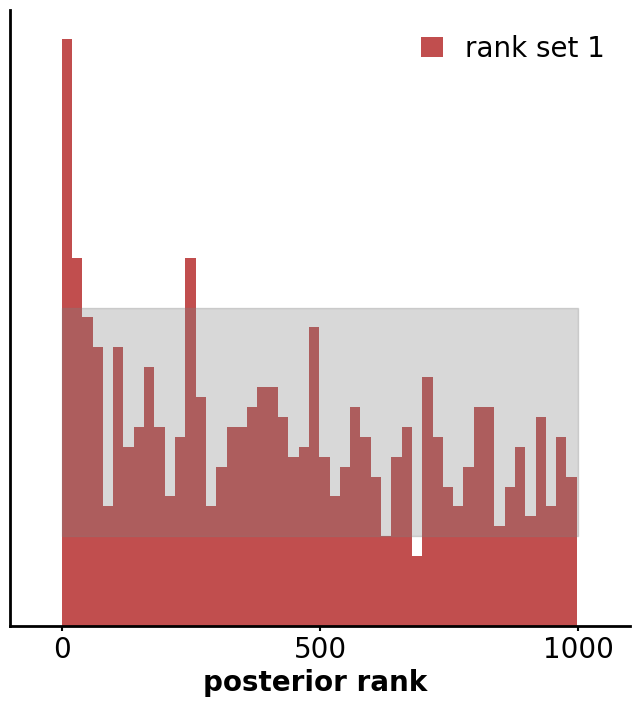

In [18]:
with mpl.rc_context(fname="plots/pltstyle.rc"):
    (fig, _) = sbc_rank_plot(
        figsize=(8,8),
        ranks=ranks,
        num_posterior_samples=1_000,
        plot_type="hist",
        num_bins=None,
        parameter_labels=['']
    )
    
    ax = fig.get_axes()    
    
    # Hide the top and right spines
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    
    # Optionally, adjust the ticks
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].yaxis.set_ticks_position('left')
    
    
    fig.savefig('plots/calibration/sbcc/block_hist.svg')
